In [52]:
# newsAPI     =    0b1ea46e336d40e1abc48f51e01c253a

In [14]:
import pandas as pd
import numpy as np
from transformers import pipeline
from tqdm import tqdm
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # Import Vader
# from collections import defaultdict
# from datetime import timedelta


## load the data

In [2]:
df = pd.read_csv('testData.csv')

# convert the publish_date column to datetime64
df['publish_date'] = pd.to_datetime(df['publish_date'])

# convert remaining cols to string
df['headline_text'] = df['headline_text'].astype(str)
df['description'] = df['description'].astype(str)


headlines_df = df.copy()
headlines_df['headline_sentiment'] = 0
headlines_df['description_sentiment'] = 0
headlines_df['emotion'] = 0
# headlines_df['pos_sentiment'] = 0
# headlines_df['neg_sentiment'] = 0

print(headlines_df.dtypes)
headlines_df.head()

total_headlines = len(headlines_df)

headlines = df['headline_text'].tolist()
descriptions = df['description'].tolist()

publish_date             datetime64[ns, UTC]
headline_text                         object
description                           object
headline_sentiment                     int64
description_sentiment                  int64
emotion                                int64
dtype: object


In [6]:
valid_emotions = ['joy', 'others', 'surprise',
                  'sadness', 'fear', 'anger', 'disgust']


emotions =  {"joy": 0, "others": 0, "surprise": 0, 
             "sadness": 0, "fear": 0, "anger": 0, "disgust": 0}


keywords = {}

# emotions = {}


## load the models

In [3]:
# sentiments = defaultdict(lambda: defaultdict(int))
sentiment_model = pipeline(
    model="siebert/sentiment-roberta-large-english")  # Use device 0 for GPU

emotion_model = pipeline(
    model="finiteautomata/bertweet-base-emotion-analysis")

keyword_ext_model = pipeline(
    model="yanekyuk/bert-keyword-extractor")

keyword_senti_model = pipeline(
    model="cardiffnlp/twitter-roberta-base-sentiment-latest")


pytorch_model.bin: 100%|██████████| 1.42G/1.42G [01:06<00:00, 21.4MB/s]
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
pytorch_model.bin: 100%|██████████| 431M/431M [00:22<00:00, 19.1MB/s] 
tokenizer_config.json: 100%|██████████| 320/320 [00:00<00:00, 145kB/s]
vocab.txt: 100%|██████████| 213k/213k [00:00<00:00, 497kB/s]
tokenizer.json: 100%|██████████| 669k/669k [00:00<00:00, 1.29MB/s]
config.json: 100%|██████████| 929/929 [00:00<00:00, 2.37MB/s]
pytorch_model.bin:  77%|███████▋  | 388M/501M [00:18<00:05, 20.5MB/s] Error while downloading from https://cdn-lfs.huggingface.co/repos/1c/bc/1cbc44949d679770c89bc0ea73a06cbaa10d775cc6e8ef4f51045bfd8309c389/4d24a3e32a88ed1c4e5b789fc6644e2e767500554e954b27dccf52a8e762cbae?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27pytorch_model.bin%3B+filename%3D%22pytorch_model.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1707836300&Policy=eyJTdGF0

## helper methods

In [7]:
def extract_keywords(batch_headlines):
    batch_results = keyword_ext_model(batch_headlines)

    # keywords = {}

    # print(batch_results)

    for result in batch_results:
        # for keyword_info in result:
        # print(result)
        keyword = result['word']
        # print(keyword)
        # Filter words with less than 2 letters, exclude hashtags, and exclude "chin"
        if keyword and len(keyword) >= 3 and not keyword.startswith('#') and keyword.lower() != 'chin':
            if keyword in keywords.keys():
                keywords[keyword] += 1
            else:
                keywords[keyword] = 1

    return keywords

In [8]:
## analyse headlines ##
with tqdm(total=total_headlines, desc="Analysing Sentiments", unit="headline", dynamic_ncols=True) as pbar:
    for idx in range(total_headlines):
        row = headlines_df.iloc[idx]
        headline = row['headline_text']
        description = row['description']


        result = sentiment_model(headline)
        label = result[0]['label']

        if label == 'POSITIVE':
            headlines_df.at[idx, 'headline_sentiment'] = 1
        elif label == 'NEGATIVE':
            headlines_df.at[idx, 'headline_sentiment'] = -1

        ## analyse description ##               
        result = sentiment_model(description)
        label = result[0]['label']

        if label == 'POSITIVE':
            headlines_df.at[idx, 'description_sentiment'] = 1
        elif label == 'NEGATIVE':
            headlines_df.at[idx, 'description_sentiment'] = -1
        

        ## analyse emotions ##
        results = emotion_model(headline)

        for result in results:
            label = result['label']
            if label in valid_emotions:

                if label not in emotions:
                    emotions[label] = 0

                emotions[label] += 1

                headlines_df.at[idx, "emotion"] = label

        ## analyse keywords ##
        results = extract_keywords(headline)


        pbar.update(1)

Analysing Sentiments: 100%|██████████| 5/5 [00:01<00:00,  2.61headline/s]


In [9]:
batch_headlines = " ".join(headlines) + " ".join(descriptions)

extract_keywords(batch_headlines)

print(keywords)


{'battery': 1, 'trillion': 3, 'game': 2, 'show': 2, 'Donald': 1, 'Trump': 1, 'Joe': 1, 'administration': 1, 'tax': 1, 'electric': 1, 'vehicle': 1, 'McDonald': 1, 'Coca': 1, 'Cola': 1, 'Bernard': 1, 'Jeff': 1, 'Larry': 1, 'Ellison': 1, 'Ware': 1}


In [10]:
headlines_df.head()

# print(emotions)

,publish_date,headline_text,description,headline_sentiment,description_sentiment,emotion
0,2024-01-28 04:50:27+00:00,Elon Musk joins Trump Republicans to slam rumo...,Elon Musk joined Donald Trump and Republican c...,-1,-1,others
1,2024-01-28 00:10:36+00:00,Tesla battery explodes in Cary home after bein...,Tesla battery explodes in Cary home after bein...,-1,-1,others
2,2024-01-27 21:01:05+00:00,Here's why Biden's multi-billion-dollar EV cha...,By Will Kessler Daily Caller News Foundation T...,-1,-1,others
3,2024-01-27 17:30:00+00:00,Who wants to be a trillionaire': The game show...,A trillion dollars can purchase shares of all...,1,1,others
4,2024-01-27 16:00:00+00:00,ARGHHH FUCK THIS,test,-1,1,anger


In [11]:
print(emotions)

{'joy': 0, 'others': 4, 'surprise': 0, 'sadness': 0, 'fear': 0, 'anger': 1, 'disgust': 0}


In [12]:
def normalise_sentiment(lst):
    # sum of all values
    total = sum(lst)

    return total
    

senti1,senti2 = [headlines_df['headline_sentiment'].tolist(), headlines_df['description_sentiment'].tolist()]

print(senti1)
print(normalise_sentiment(senti1))

print("========================")

print(senti2)
print(normalise_sentiment(senti2))


[-1, -1, -1, 1, -1]
-3
[-1, -1, -1, 1, 1]
-1


['joy', 'others', 'surprise', 'sadness', 'fear', 'anger', 'disgust']
[0, 4, 0, 0, 0, 1, 0]


/var/folders/df/wq0_v7hn53n0z84b691yjxcc0000gn/T/ipykernel_13861/3315558368.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['joy', 'neutral', 'surprise', 'sadness', 'fear', 'anger', 'disgust'])


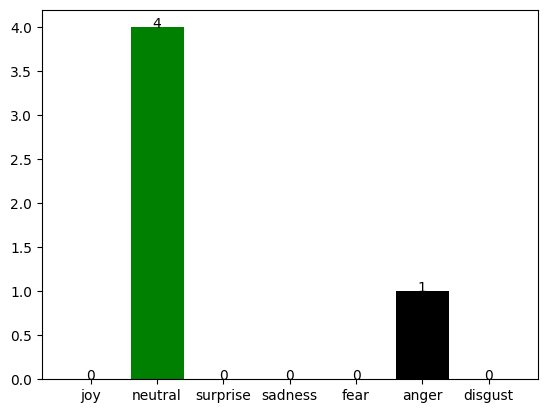

In [13]:
# some code to display emotions in a graph

fig, ax = plt.subplots()

# print(emotions.keys())

emotionList = list(emotions.keys())
valuesList = list(emotions.values())

print(emotionList)
print(valuesList)

ax.bar(emotionList, valuesList)

# show count of each emotion
for i in range(len(emotionList)):
    ax.text(i, valuesList[i], str(valuesList[i]), ha='center')

# different colors for each bar
ax.bar(emotionList, valuesList, color=['red', 'green', 'blue', 'purple', 'orange', 'black', 'pink'])

# label "others" as "neutral"
ax.set_xticklabels(['joy', 'neutral', 'surprise', 'sadness', 'fear', 'anger', 'disgust'])


plt.show()


ValueError: Only supported for TrueType fonts

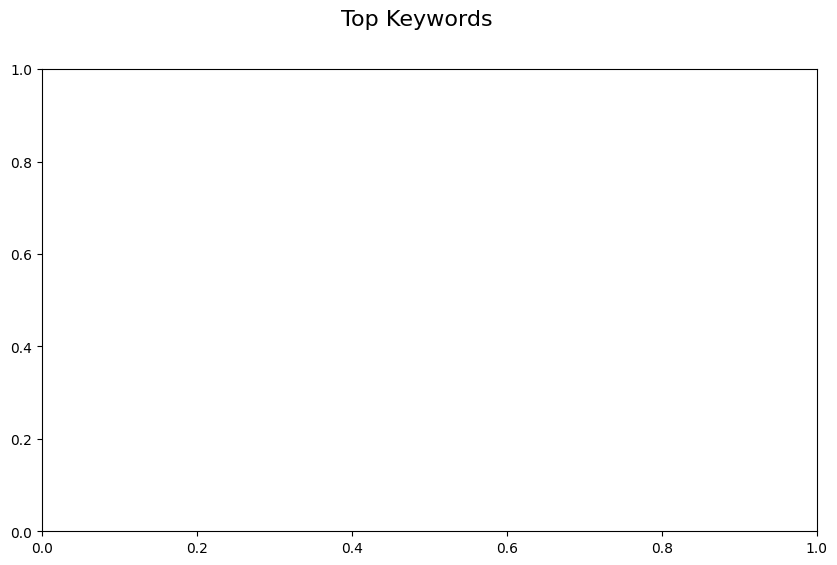

In [25]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # Import Vader

# Define the keywords dictionary
# keywords = {"word1": 10, "word2": 20, "word3": 15, "word4": 30}  # Replace with your actual data

# Create a color mapping for sentiment (you can adjust these colors)
sentiment_colors = {
    'positive': 'green',
    'neutral': 'gray',
    'negative': 'red'
}

# Create a subplot for the word cloud
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as needed

# Create a title for the top keywords
title = fig.suptitle("Top Keywords", fontsize=16)

# Initialise Vader sentiment analyser
analyzer = SentimentIntensityAnalyzer()

# Function to analyze sentiment and assign colors to words using Vader
def analyze_sentiment_and_color(text):
    sentiment = analyzer.polarity_scores(text)
    compound_score = sentiment['compound']
    
    if compound_score > 0:
        return sentiment_colors['positive']
    elif compound_score < 0:
        return sentiment_colors['negative']
    else:
        return sentiment_colors['neutral']

# Function to update the word cloud
def update():
    # Analyse sentiment and assign colors to words
    colors = {word: analyze_sentiment_and_color(word) for word in keywords.keys()}

    # Create a word cloud with colored words
    wordcloud = WordCloud(
        width=400, height=200, max_words=50, background_color='white',
        color_func=lambda word, font_size, position, orientation, random_state=None, **kwargs: colors.get(word, 'black'),
        font_path=None
        # font_name="Arial" 
    ).generate_from_frequencies(keywords)

    # Update the word cloud on the subplot
    ax.clear()
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')

    fig.canvas.draw_idle()

# Initialise the word cloud
update()

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
wordcloud = WordCloud(width=800, height=400)

# Generate a word cloud from the word:count dictionary
wordcloud.generate_from_frequencies(frequencies=keywords)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()